In [1]:
import utils
import numpy as np
from matplotlib import pyplot

from sklearn import decomposition, svm, linear_model, metrics, ensemble


c:\program files\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Looking at the combined wine quality dataset...
# Two quantities of interest we might be interested in here!
#
# 1. Wine "quality"; a numerical score with 0 being poop, 10 being amazing
# 2. Type of wine.
#
# As predicted by a collection of 11 measurements on the wine.
#
# This dataset is loaded into a pandas dataframe using our helper script.
#

df = utils.load_wine()
print('Dataset shape (including quality; wine type): ',df.shape)

# pull out data, quantities of interest for prediction
data = np.array( df.values[:,:-2], dtype=float )

qualities = df['quality'].values
types = df['type'].values

# build an equivalence class for our own convenience again...
ec = {w: np.where(df['type'].values == w)[0] for w in ['red', 'white']}

# choose a couple colors for the wine types.
red_col = [0.447, 0.184, 0.012]
white_col = [0.945, 0.949, 0.522]
palette = [red_col, white_col]

palette_map = {'red':red_col, 'white':white_col}

Dataset shape (including quality; wine type):  (6497, 13)


In [3]:
# Study the first entry to get an idea
df.iloc[0]

fixed acidity              7.4
volatile acidity           0.7
citric acid                  0
residual sugar             1.9
chlorides                0.076
free sulfur dioxide         11
total sulfur dioxide        34
density                 0.9978
pH                        3.51
sulphates                 0.56
alcohol                    9.4
quality                      5
type                       red
Name: 0, dtype: object

Text(0, 0.5, 'pc2')

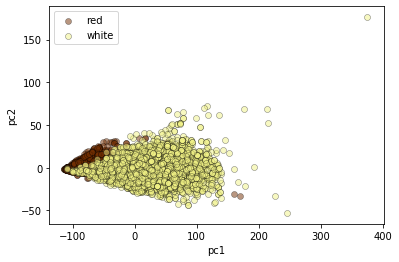

In [4]:
# Try a PCA to see if the data can be separated in two dimensions
pca = decomposition.PCA(n_components=2)

comps = pca.fit_transform(data)

fig,ax = pyplot.subplots(1,1)
for k,v in ec.items():
    ax.scatter(comps[v,0], comps[v,1], c=[palette_map[k]], edgecolor='k', linewidth=0.5, alpha=0.5, label=k)
ax.legend()
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')

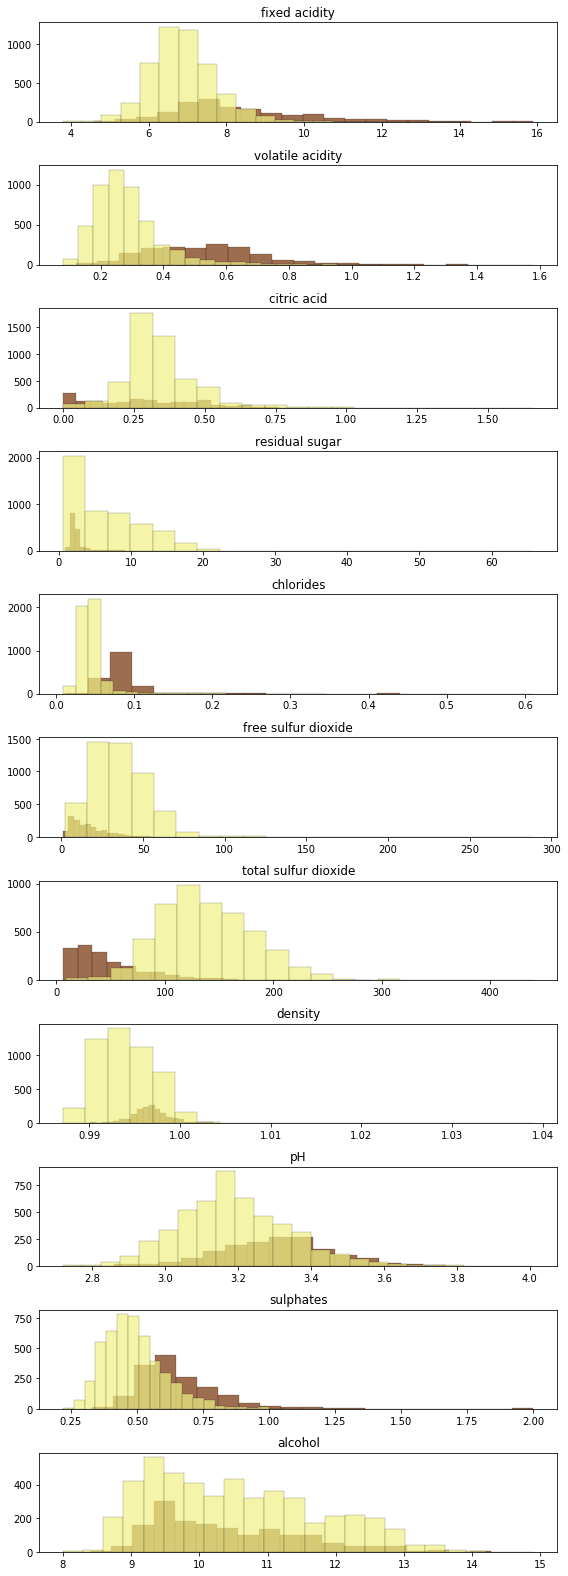

In [5]:
fig2,ax2 = pyplot.subplots(df.shape[1]-2, 1, figsize=(8,22))
for j,attribute in enumerate( list(df)[:-2]):
    for k,v in ec.items():
        ax2[j].hist(data[v,j], bins=21,
                    color=palette_map[k], label=k, alpha=0.7, linewidth=0.25, edgecolor='k')
        ax2[j].set_title(attribute)

#fig2.tight_layout()

In [6]:
# Staring at the histograms --
# 1. Indeed some variables seem not predictive at all; for instance 
#    alcohol, citric acid, density, pH. 
# 2. Others however, seem to have some univariate separation power:
#    volatile acidity, chlorides, total sulfur dioxide, sulphates.
#
# If we focus only on these variables, how do the pictures change?
#

good_features = ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates']
data_sub = df[good_features].values


Text(0, 0.5, 'pc2')

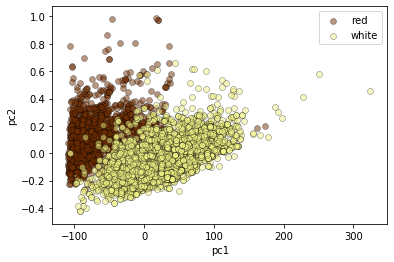

In [7]:
comps2 = pca.fit_transform(data_sub)

fig3,ax3 = pyplot.subplots(1,1)
for k,v in ec.items():
    ax3.scatter(comps2[v,0], comps2[v,1], c=[palette_map[k]], edgecolor='k', linewidth=0.5, alpha=0.5, label=k)
ax3.legend()
ax3.set_xlabel('pc1')
ax3.set_ylabel('pc2')

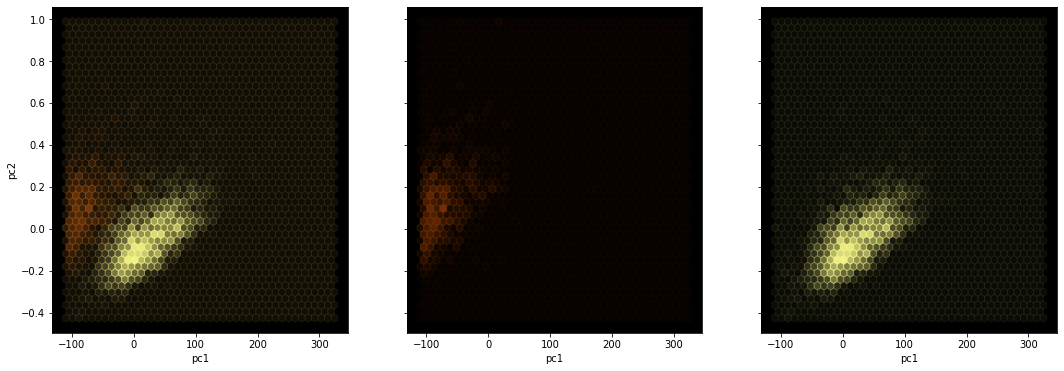

In [8]:
# an alternative...
from matplotlib.colors import ListedColormap

reds_cmap = np.ones((256,4))
reds_cmap[0,:3] = red_col
reds_cmap[0,3] = 0.05
reds_cmap[-1,:3] = red_col
for k,t in enumerate(np.linspace(0,1,256)):
    val = (1.-t)*reds_cmap[0] + t*reds_cmap[-1]
    reds_cmap[k]=val
reds_cmap = ListedColormap(reds_cmap)

whites_cmap = np.ones((256,4))
whites_cmap[0,:3] = white_col
whites_cmap[0,3] = 0.05
whites_cmap[-1,:3] = white_col
for k,t in enumerate(np.linspace(0,1,256)):
    val = (1.-t)*whites_cmap[0] + t*whites_cmap[-1]
    whites_cmap[k]=val
whites_cmap = ListedColormap(whites_cmap)

fig4,ax4 = pyplot.subplots(1,3, figsize=(18,6), sharex=True, sharey=True)
for j,(k,v) in enumerate(ec.items()):
    ax4[0].hexbin(comps2[v,0], comps2[v,1], gridsize=41, extent=[comps2[:,0].min(), comps2[:,0].max(), comps2[:,1].min(), comps2[:,1].max()], cmap=[reds_cmap,whites_cmap][j])
    ax4[j+1].hexbin(comps2[v,0], comps2[v,1], gridsize=41, extent=[comps2[:,0].min(), comps2[:,0].max(), comps2[:,1].min(), comps2[:,1].max()], cmap=[reds_cmap,whites_cmap][j])
    ax4[j+1].set_facecolor('k')
    ax4[j+1].set_xlabel('pc1')
#
ax4[0].set_facecolor('k')
ax4[0].set_xlabel('pc1')
ax4[0].set_ylabel('pc2')
fig.tight_layout()

c:\program files\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


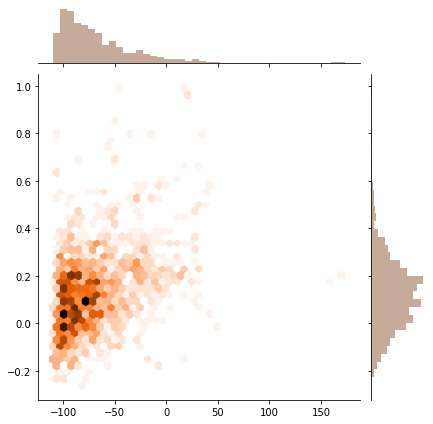

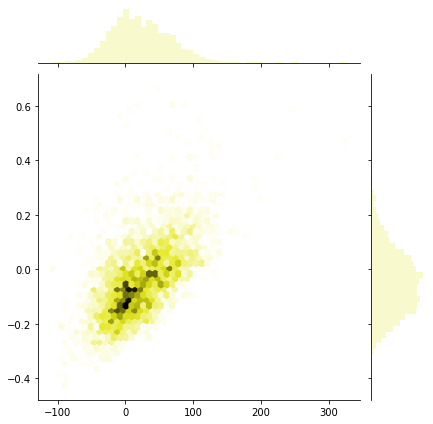

In [9]:
# seaborn mention...
import seaborn

seaborn.jointplot(comps2[ec['red'],0], comps2[ec['red'],1], kind='hex', color=red_col)
seaborn.jointplot(comps2[ec['white'],0], comps2[ec['white'],1], kind='hex', color=white_col)


In [10]:
# Briefly see how well the data separates (forget about train/testing for now).
svc = svm.LinearSVC(random_state=31415)
svc.fit(data,types)
preds = svc.predict(data)

print('Working with all wine properties gives training set accuracy: ',sum(preds==types)/len(types))
svc = svm.LinearSVC(random_state=31415)
svc.fit(data_sub,types)
preds_sub = svc.predict(data_sub)

print('Working with manually selected wine properties gives training set accuracy: ',sum(preds_sub==types)/len(types))


Working with all wine properties gives training set accuracy:  0.9843004463598584
Working with manually selected wine properties gives training set accuracy:  0.9702939818377713


In [11]:
# Great - seem to get decent results even looking at four of the eleven wine properties in predicting the 
# type of wine. But this needed us to manually pick out "good" features. How can we do this automatically?
#
lasso = linear_model.Lasso(alpha=1e-2)
wine2int = {'red':0, 'white':1}
labs = np.array( [wine2int[w] for w in types] )

lasso.fit(data,labs)
preds_las0 = lasso.predict(data)

threshold = 0.5
preds_thr0 = (preds_las0 > threshold)
print('Working with all wine properties with LASSO gives training set accuracy: ',sum(preds_thr0==labs)/len(labs))

print(metrics.classification_report(labs, preds_thr0>threshold))

Working with all wine properties with LASSO gives training set accuracy:  0.9726027397260274
             precision    recall  f1-score   support

          0       0.97      0.92      0.94      1599
          1       0.97      0.99      0.98      4898

avg / total       0.97      0.97      0.97      6497



(-0.05, 1.05, -0.049785626786443445, 1.0502143732135567)

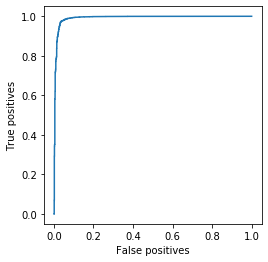

In [12]:
# Different choices of thresholds will give different predictions. Your appetite for false predictions 
# of whites or reds can affect your threshold from the "traditional" 0.5 value.

rx,ry,_ = metrics.roc_curve(labs, preds_las0)
fig5,ax5 = pyplot.subplots(1,1)

ax5.plot(rx,ry)
ax5.set_xlabel('False positives')
ax5.set_ylabel('True positives')
ax5.axis('square')

In [19]:
lasso.coef_

array([-0.0787756 , -0.54483149,  0.        ,  0.00474215, -0.        ,
       -0.00281996,  0.00462206, -0.        , -0.15454043, -0.13469312,
        0.05380697])

[ 4.81057472e-02 -4.55297327e-01  1.30172687e-01  5.22472163e-02
 -7.57025398e-01 -2.85843606e-03  2.98512951e-03 -1.35450841e+02
  1.64557113e-01 -1.28710917e-01 -1.22768824e-01]
[ 3.36740230e-01 -1.32036225e-01  4.03535330e-02  1.56741649e-01
 -3.55801937e-02 -8.28946456e-02  3.52245282e-01 -1.34758687e+02
  5.28228333e-01 -6.56425675e-02 -1.26451889e+00]


(-0.05, 1.05, -0.049785626786443445, 1.0502143732135567)

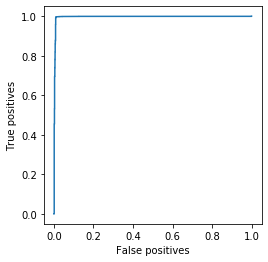

In [20]:
lr = linear_model.LinearRegression()
lr.fit(data,labs)
print(lr.coef_)
print(lr.coef_*np.median(data, axis=0))

preds_lr0 = lr.predict(data)

rx,ry,_ = metrics.roc_curve(labs, preds_lr0)
fig6,ax6 = pyplot.subplots(1,1)

ax6.plot(rx,ry)
ax6.set_xlabel('False positives')
ax6.set_ylabel('True positives')
ax6.axis('square')

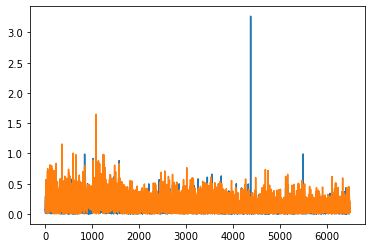

In [21]:
fig6,ax6 = pyplot.subplots(1,1)
ax6.plot(np.abs(labs - preds_lr0))
ax6.plot(np.abs(labs - preds_las0))

In [13]:
# Let's try to study the question of quality.
# This time, we'll do something a little more complex -- repeated randomized train/test 
# and collecting information about the models.
# This is sometimes called bootstrapping.
# Many other related ideas exist to improve *robustness* of models.
#

which_wine = 'red'

nrep = 10
seed = 271828


###

idx = np.where(types==which_wine)[0]
data_sub = data[idx]
qualities = df['quality'].iloc[idx].values
nw = len(idx)
tr_len = nw//2
te_len = nw - tr_len

np.random.seed(seed)
weights = np.zeros((nrep,data.shape[1]))

tr_truths = np.zeros((nrep,tr_len))
te_truths = np.zeros((nrep,te_len))
tr_preds = np.zeros((nrep,tr_len))
te_preds = np.zeros((nrep,te_len))

for i in range(nrep):
    #lm = linear_model.Lasso(alpha=0.0001)
    lm = ensemble.RandomForestRegressor(n_estimators=100, criterion='mae')
    order = np.random.permutation(nw)
    tr_idx = order[:tr_len]
    te_idx = order[tr_len:]
    
    lm.fit(data_sub[tr_idx], qualities[tr_idx])
    
    tr_pred = lm.predict(data_sub[tr_idx])
    te_pred = lm.predict(data_sub[te_idx])
    
    tr_truths[i] = qualities[tr_idx]
    te_truths[i] = qualities[te_idx]
    tr_preds[i] = tr_pred
    te_preds[i] = te_pred
    
    #weights[i] = lm.coef_
    #print(sum(abs(lm.coef_)), te_pred)
    if i%1==0:
        print(i)
#
print('done')

0
1
2
3
4
5
6
7
8
9
done


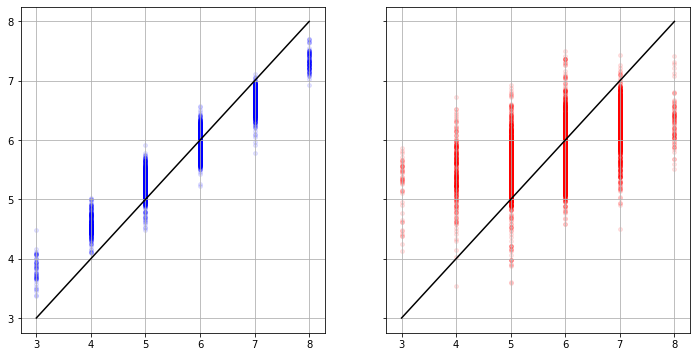

In [14]:
fig7,ax7 = pyplot.subplots(1,2, sharex=True, sharey=True, figsize=(12,6))
for i in range(nrep):
    ax7[0].scatter(tr_truths[i], tr_preds[i], c='b', alpha=0.1, s=15)
    ax7[1].scatter(te_truths[i], te_preds[i], c='r', alpha=0.1, s=15)
#
ax7[0].plot([3,8],[3,8], c='k')
ax7[1].plot([3,8],[3,8], c='k')
ax7[0].grid()
ax7[1].grid()

In [ ]:
pyplot.pcolormesh(abs(weights)*np.median(data_sub, axis=0))
pyplot.colorbar()

In [ ]:
# Study the median weight scaled relative to data magnitude, to get at relative contribution/importance.
feature_importance_order = np.argsort(-np.median(np.abs(weights)*np.median(data_sub,axis=0), axis=0))

df.columns[feature_importance_order]

In [ ]:
# Let's see how the first three do in predicting supposed quality...
lr = linear_model.LinearRegression()
data_sub_feat = data_sub[:,feature_importance_order[:3]]
lr.fit()

In [ ]:
ensemble.RandomForestRegressor?